In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Read Benchmark Data

In [31]:
benchmark_results_path = "../results/"
data = []
for root, dirs, files in os.walk(benchmark_results_path):
    for file in files:
        if file.endswith(".csv"):
            df_ = pd.read_csv(os.path.join(root, file))
            data.append(df_)

df = pd.concat(data)

In [32]:
df.head()

,model_name,env_id,prompt_chain,context_length,episode_reward,episode_length
0,meta-llama/Llama-3.2-1B-Instruct,SpaceInvaders,simple,0,295.0,621
1,meta-llama/Llama-3.2-1B-Instruct,SpaceInvaders,simple,0,180.0,491
2,meta-llama/Llama-3.2-1B-Instruct,SpaceInvaders,simple,0,150.0,365


### Aggregate Results for each Benchmark run

In [33]:
df['mean_reward'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'context_length'])['episode_reward'].transform('mean')
df['std_reward'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'context_length'])['episode_reward'].transform('std')
df['mean_length'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'context_length'])['episode_length'].transform('mean')
df['std_length'] = df.groupby(['model_name', 'env_id', 'prompt_chain', 'context_length'])['episode_length'].transform('std')

### Plot

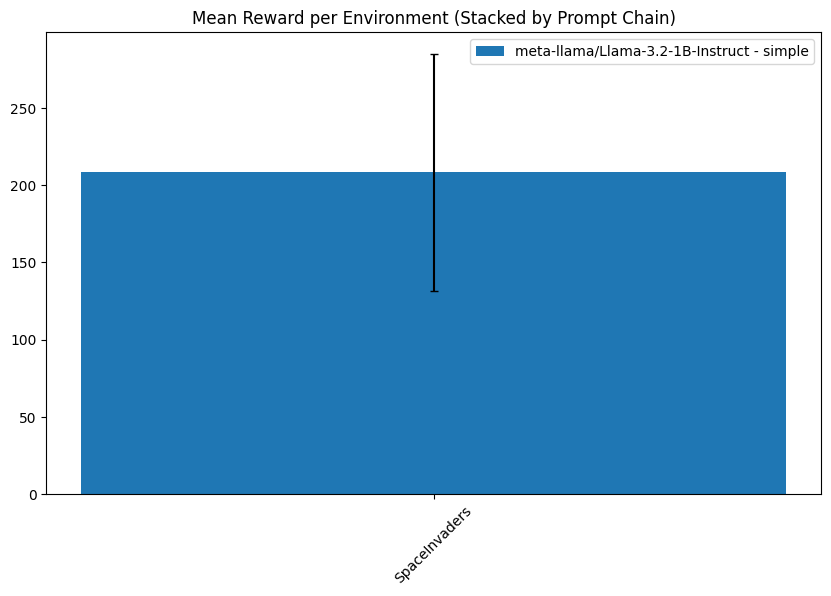

In [34]:
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))

# Sort data for consistency
df = df.sort_values(by=['model_name', 'prompt_chain'])

# Get unique values
envs = df['env_id'].unique()
models = df['model_name'].unique()

# Define width for grouped bars
bar_width = 0.6
bar_positions = np.arange(len(envs))

# Store bottom positions for stacking
bottoms = {env: 0 for env in envs}

# Iterate over models and prompt_chain to stack bars
for model in models:
    subset = df[df['model_name'] == model]
    
    for prompt_chain in subset['prompt_chain'].unique():
        sub_subset = subset[subset['prompt_chain'] == prompt_chain]
        
        means = sub_subset.groupby('env_id')['mean_reward'].mean()
        stds = sub_subset.groupby('env_id')['std_reward'].mean()

        ax.bar(
            means.index, 
            means.values, 
            yerr=stds.values, 
            label=f"{model} - {prompt_chain}", 
            bottom=[bottoms[env] for env in means.index],
            capsize=3
        )

        # Update bottom positions for stacking
        for env in means.index:
            bottoms[env] += means[env]

ax.set_xticks(bar_positions)
ax.set_xticklabels(envs, rotation=45)
plt.legend()
plt.title('Mean Reward per Environment (Stacked by Prompt Chain)')
plt.show()
